## VSSL (1) vs NSL (0)

### Import Libraries

In [1]:
from util_comp import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import time
import warnings

import xgboost


from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression

# Makes sure we see all columns
pd.set_option('display.max_columns', None)

# ignore warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
df = pd.DataFrame(main(retained=True, string_issue=True))
print(df.shape)
df.head()

Elapsed time to compute age categorisation: 0 minutes and 0 seconds
Elapsed time to compute correct systematic error: 0 minutes and 13 seconds
Elapsed time to compute load column names: 0 minutes and 0 seconds
Elapsed time to compute clean data: 0 minutes and 0 seconds
Elapsed time to compute categorisation of outcome column: 0 minutes and 4 seconds
Elapsed time to compute change values > opt: 2 minutes and 1 seconds
Elapsed time to compute Full process: 2 minutes and 18 seconds
(44535, 100)


YEAR MMS  Q1- Your sex?  Q2- How old are you?  STATUS  \
0         1            2.0                   NaN     4.0   
1         1            2.0                   NaN     3.0   
2         1            2.0                   NaN     3.0   
3         1            2.0                   NaN     3.0   
4         1            2.0                   NaN     2.0   

   In which sector of activity do you work?  \
0                                       1.0   
1                                       3.0   
2                                       3.0   
3                                       3.0   
4                                       3.0   

   What is the size of your business (in total, all locations combined)? 2009 fake  \
0                                                3.0                                 
1                                                3.0                                 
2                                                3.0                                 
3                                                4.0                                 
4                                                3.0                                 

   Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?  \
0                                                0.0                                                                   
1                                                0.0                                                                   
2                                                2.0                                                                   
3                                                0.0                                                                   
4                                                0.0                                                                   

   Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?  \
0                                                0.0                                                                    
1                                                0.0                                                                    
2                                                0.0                                                                    
3                                                0.0                                                                    
4                                                0.0                                                                    

   Q4- (13 to 17 years old) In each of the following age groups, how many children live totally or partially with you?  \
0                                                0.0                                                                     
1                                                0.0                                                                     
2                                                0.0                                                                     
3                                                0.0                                                                     
4                                                2.0                                                                     

   Q4- (18 years and over) In each of the following age groups, how many children live totally or partially with you?  \
0                                                0.0                                                                    
1                                                0.0                                                                    
2                                                0.0                                                                    
3                                                0.0                                                                    
4                                                2.0    

In [3]:
df.describe()

YEAR MMS  Q1- Your sex?  Q2- How old are you?        STATUS  \
count  44535.000000   44501.000000          42194.000000  44533.000000   
mean       5.725250       1.470596              3.022231      2.602677   
std        2.753581       0.499140              1.604283      1.159376   
min        1.000000       1.000000              1.000000      1.000000   
25%        3.000000       1.000000              2.000000      1.000000   
50%        6.000000       1.000000              3.000000      3.000000   
75%        8.000000       2.000000              4.000000      4.000000   
max       10.000000       2.000000              6.000000      4.000000   

       In which sector of activity do you work?  \
count                              44533.000000   
mean                                   4.367009   
std                                    2.916375   
min                                    1.000000   
25%                                    1.000000   
50%                                    3.000000   
75%                                    8.000000   
max                                    9.000000   

       What is the size of your business (in total, all locations combined)? 2009 fake  \
count                                       44509.000000                                 
mean                                            2.829630                                 
std                                             1.268036                                 
min                                             1.000000                                 
25%                                             2.000000                                 
50%                                             3.000000                                 
75%                                             4.000000                                 
max                                             6.000000                                 

       Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?  \
count                                       42873.000000                                                                   
mean                                            0.204604                                                                   
std                                             0.495812                                                                   
min                                             0.000000                                                                   
25%                                             0.000000                                                                   
50%                                             0.000000                                                                   
75%                                             0.000000                                                                   
max                                             9.000000                                                                   

       Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?  \
count                                       42872.000000                                                                    
mean                                            0.272229                                                                    
std                                             0.599071                                                                    
min                                             0.000000                                                                    
25%                                             0.000000                                                                    
50%                                             0.000000                                                                    
75%                                             0.000000                         

#### split data to train and test sets

In [4]:
data = df

# Split the data for training and evaluation
# X: features with the outcome column removed, where outcome is 0 or 1
# y: outcome column

# get the rows withs outcome 0 or 1
X = data[(data['outcome'] == 0) | (data['outcome'] == 1)].drop('outcome', axis=1, inplace=False)
X.columns = [str(i) for i in X.columns]
y = data[(data['outcome'] == 0) | (data['outcome'] == 1)]['outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


#### Train the Random Forest model

In [5]:
# Fit RF (blackbox) model
t1 = time.time()
sl = RandomForestClassifier(class_weight='balanced')
sl.fit(X_train, y_train)
t2 = time.time()
print(time_e(t1, t2, "fitting RF model"))

Elapsed time to compute fitting RF model: 0 minutes and 4 seconds


In [6]:
y_pred = sl.predict(X_test)
y_pred_proba = sl.predict_proba(X_test)

In [7]:
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy of test: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy of train: {accuracy_score(y_train, sl.predict(X_train))}")

# ROAUC

print(f"ROAUC: {roc_auc_score(y_test, y_pred_proba[:,1])}")
print(f"Confusin matrix: \n{confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

F1 Score: 0.5423235158713837
Accuracy of test: 0.8642046271015951
Accuracy of train: 0.9999640701350963
ROAUC: 0.7541342822484512
Confusin matrix: 
[[5925    6]
 [ 939   89]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      5931
           1       0.94      0.09      0.16      1028

    accuracy                           0.86      6959
   macro avg       0.90      0.54      0.54      6959
weighted avg       0.87      0.86      0.81      6959



## Explanantion using SHAP

In [8]:
explainer = shap.TreeExplainer(sl)

# Calculate shapley values for test data
start_index = 0
end_index = 10

# time to run 10 samples
s_time = time.time()
shap_values = explainer.shap_values(X_test[start_index:end_index]) # 0 - 9
e_time = time.time()
time_e(s_time, e_time, f"Shapley values for test data[{start_index}:{end_index}]")
X_test[start_index:end_index]

YEAR MMS  Q1- Your sex?  Q2- How old are you?  STATUS  \
37283         9            1.0                   1.0     3.0   
26982         7            2.0                   1.0     3.0   
38636         9            2.0                   2.0     3.0   
12905         4            2.0                   4.0     3.0   
15547         4            1.0                   3.0     1.0   
2067          1            2.0                   NaN     1.0   
31922         8            2.0                   2.0     1.0   
39880         9            1.0                   1.0     4.0   
1763          1            2.0                   NaN     1.0   
30383         8            2.0                   3.0     2.0   

       In which sector of activity do you work?  \
37283                                       8.0   
26982                                       8.0   
38636                                       9.0   
12905                                       7.0   
15547                                       3.0   
2067                                        1.0   
31922                                       1.0   
39880                                       3.0   
1763                                        3.0   
30383                                       3.0   

       What is the size of your business (in total, all locations combined)? 2009 fake  \
37283                                                2.0                                 
26982                                                1.0                                 
38636                                                3.0                                 
12905                                                3.0                                 
15547                                                3.0                                 
2067                                                 4.0                                 
31922                                                4.0                                 
39880                                                3.0                                 
1763                                                 1.0                                 
30383                                                4.0                                 

       Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?  \
37283                                                0.0                                                                   
26982                                                0.0                                                                   
38636                                                1.0                                                                   
12905                                                0.0                                                                   
15547                                                0.0                                                                   
2067                                                 0.0                                                                   
31922                                                0.0                                                                   
39880                                                0.0                                                                   
1763                                                 0.0                                                                   
30383                                                0.0                                                                   

       Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?  \
37283                                                0.0                                                                    
26982                                                0.0                                                                    
38636    

In [9]:
y_test[start_index:end_index]

37283    0
26982    0
38636    0
12905    1
15547    0
2067     0
31922    0
39880    0
1763     0
30383    0
Name: outcome, dtype: int64

### SHAP Values

In [10]:
print(shap_values[0].shape)
shap_values

(99, 2)


array([[[ 0.00310895, -0.00310895],
        [ 0.0029272 , -0.0029272 ],
        [-0.02225549,  0.02225549],
        ...,
        [ 0.00281611, -0.00281611],
        [ 0.00198332, -0.00198332],
        [ 0.02800364, -0.02800364]],

       [[-0.00731399,  0.00731399],
        [ 0.00104177, -0.00104177],
        [-0.03313292,  0.03313292],
        ...,
        [ 0.0041073 , -0.0041073 ],
        [ 0.00175718, -0.00175718],
        [-0.00954453,  0.00954453]],

       [[ 0.00330871, -0.00330871],
        [-0.0013795 ,  0.0013795 ],
        [-0.01019778,  0.01019778],
        ...,
        [ 0.00487945, -0.00487945],
        [ 0.00383145, -0.00383145],
        [ 0.00050088, -0.00050088]],

       ...,

       [[ 0.00434672, -0.00434672],
        [ 0.00216777, -0.00216777],
        [-0.02160589,  0.02160589],
        ...,
        [ 0.00375473, -0.00375473],
        [-0.00065943,  0.00065943],
        [ 0.02642331, -0.02642331]],

       [[-0.02200323,  0.02200323],
        [-0.00092231,  0.00

In [11]:
shap.initjs()
# Force plot
prediction = sl.predict(X_test[start_index:end_index])[0]
print(f"The sl predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[...,1],
                X_test[start_index:end_index])  # for values

The sl predicted: 0


### Summary of Variables that affected the prediction using SHAP

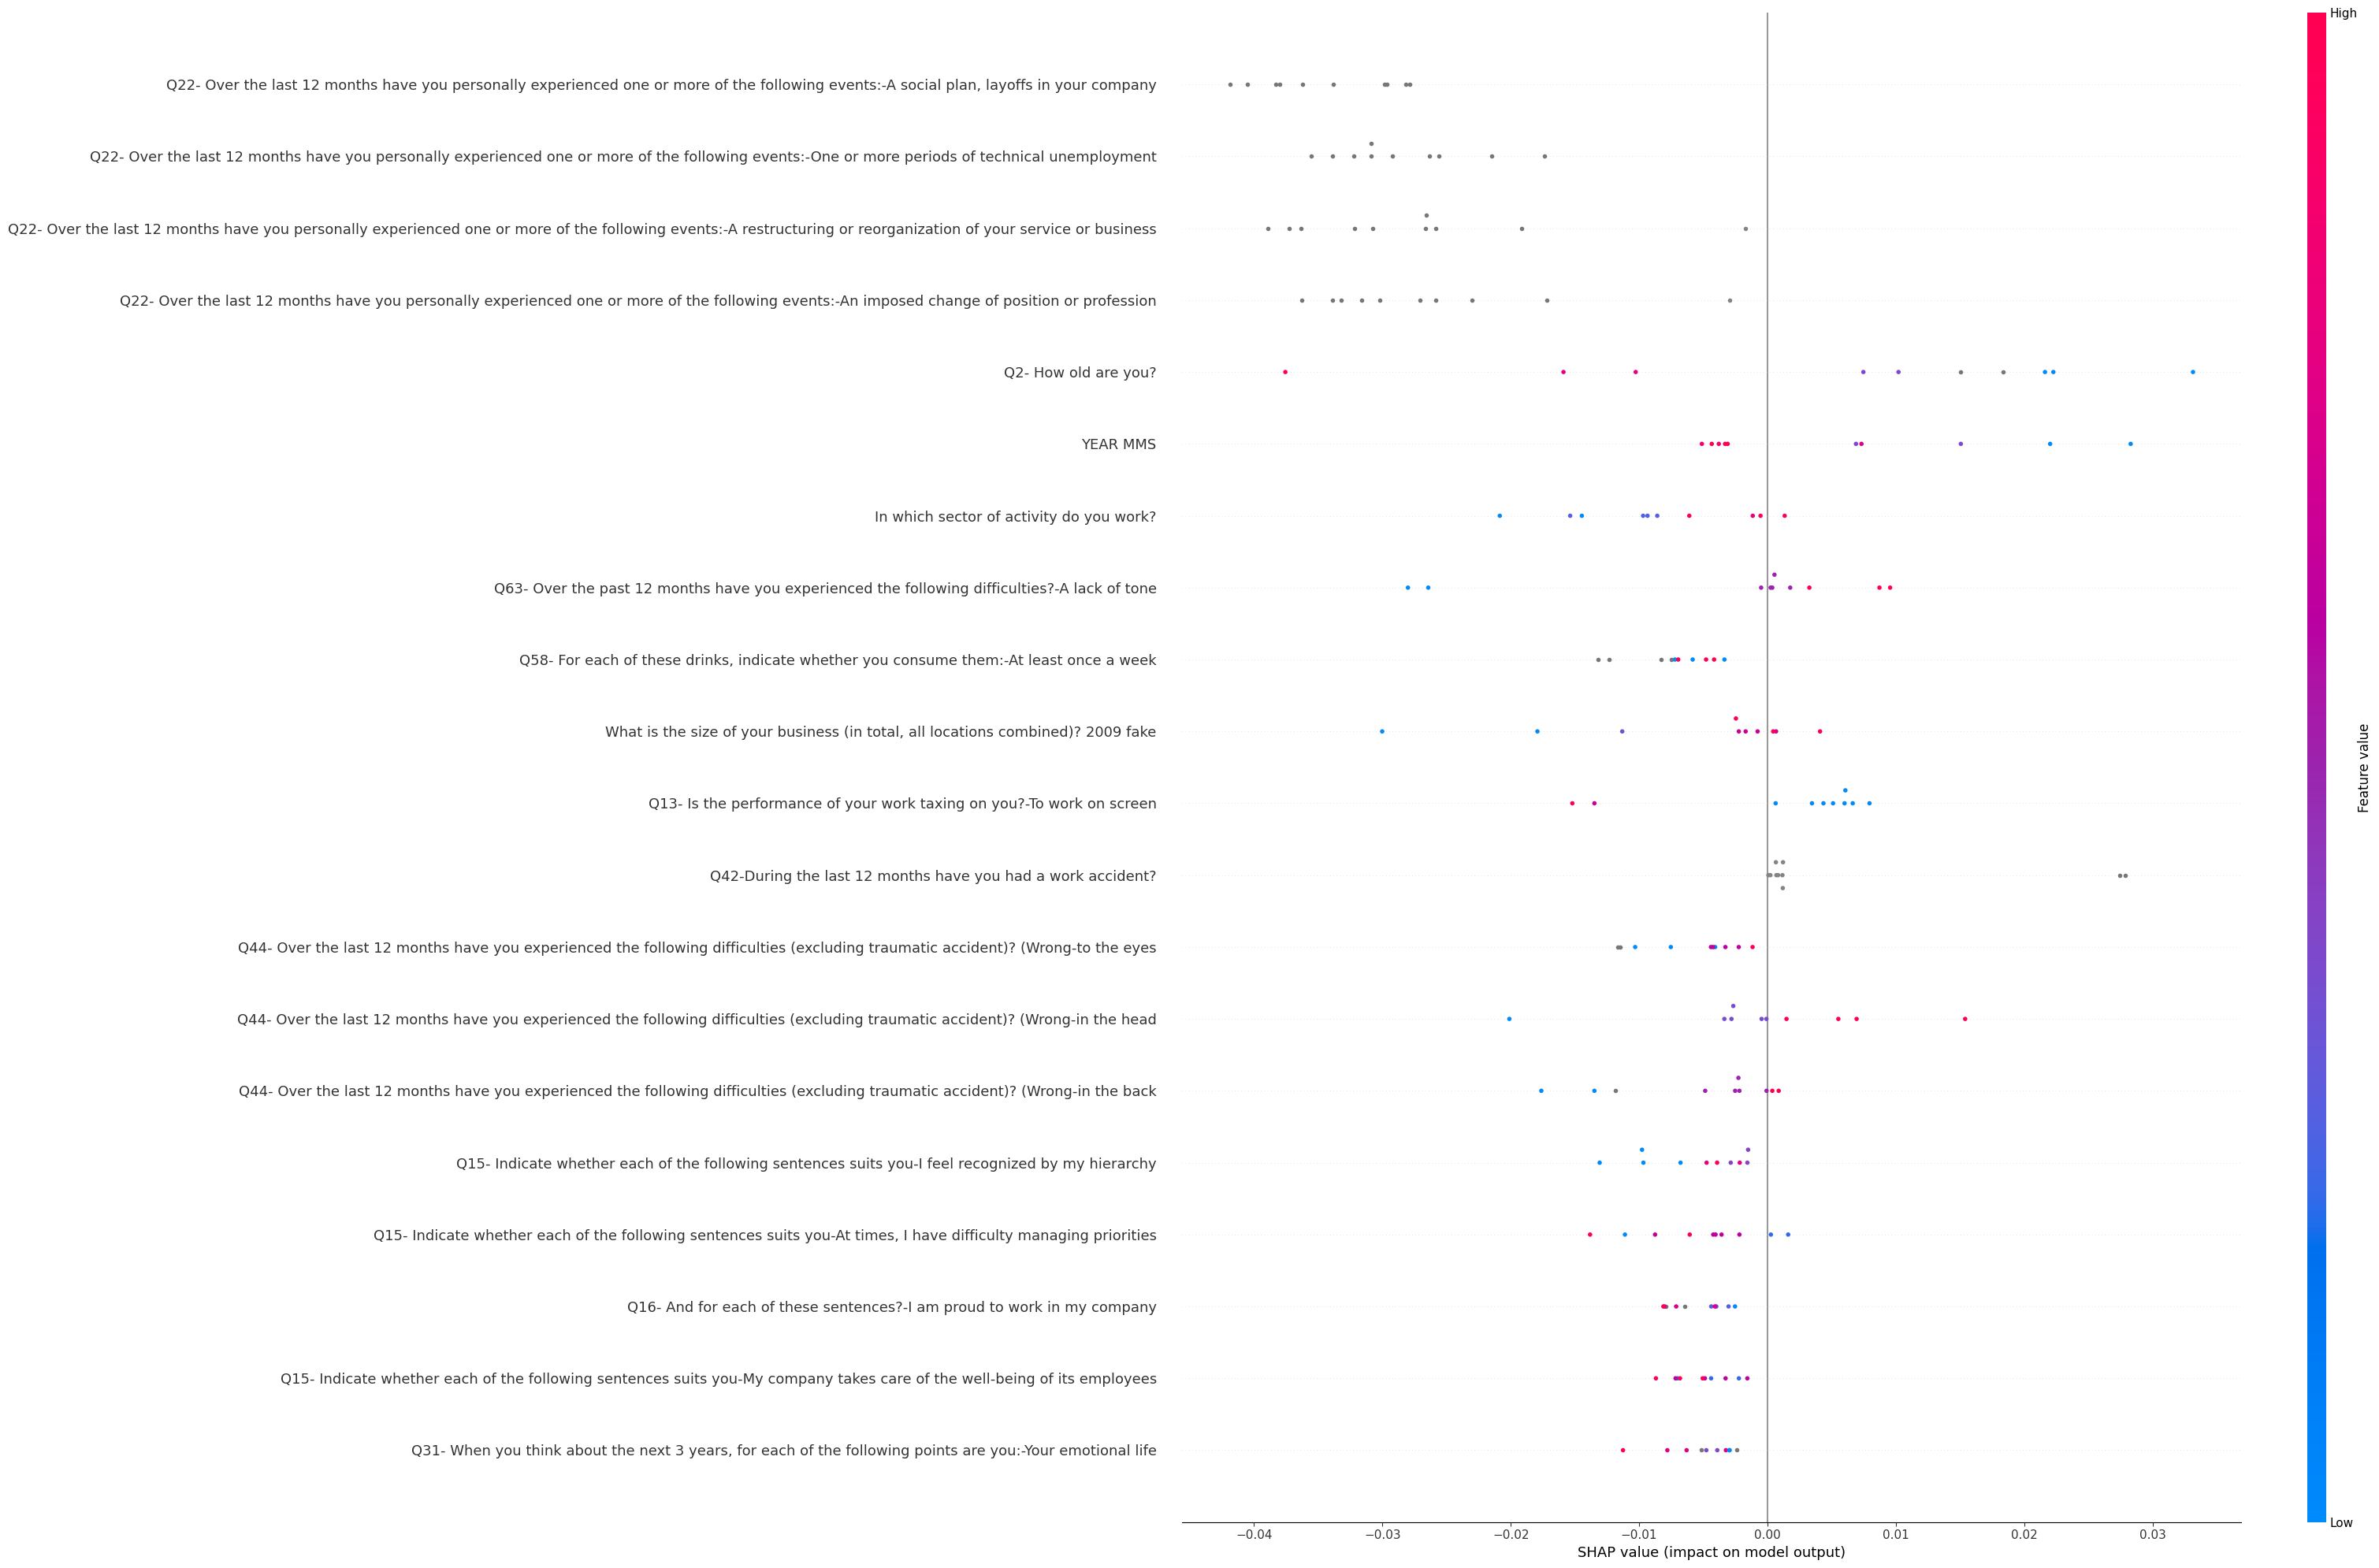

In [12]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_for_10_samples.png')
plt.show()

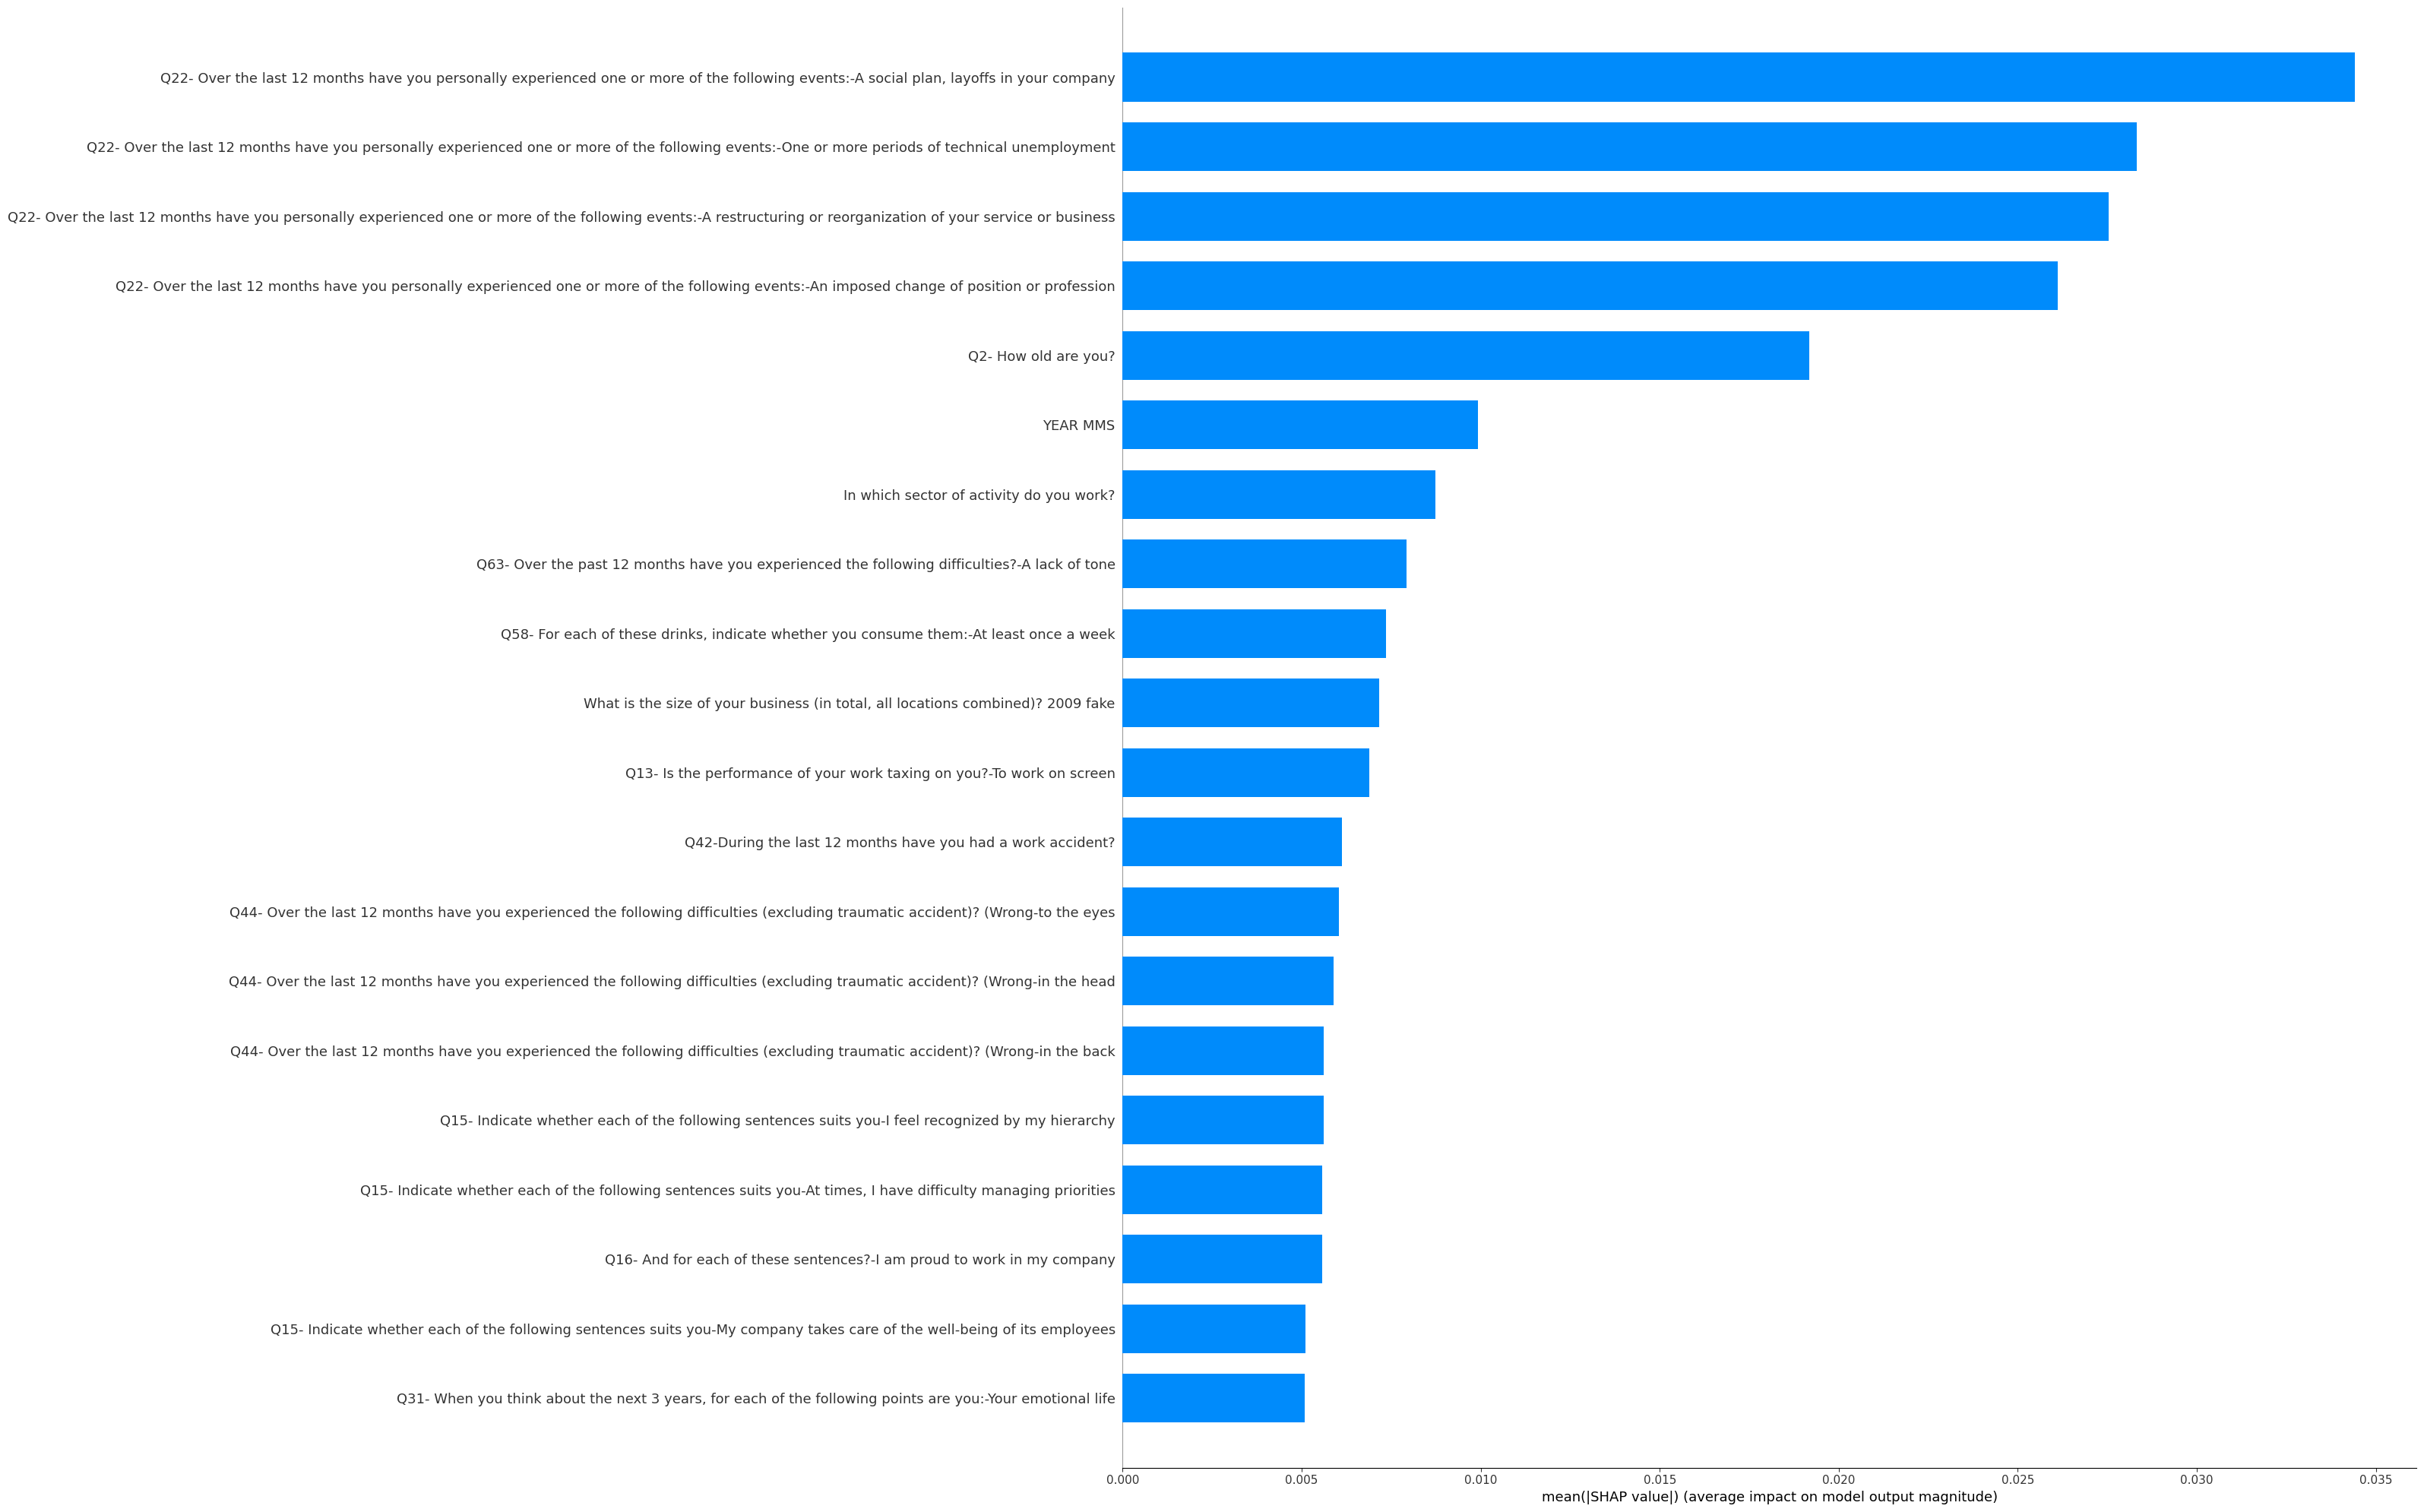

In [13]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_bar_for_10_samples.png')
plt.show()

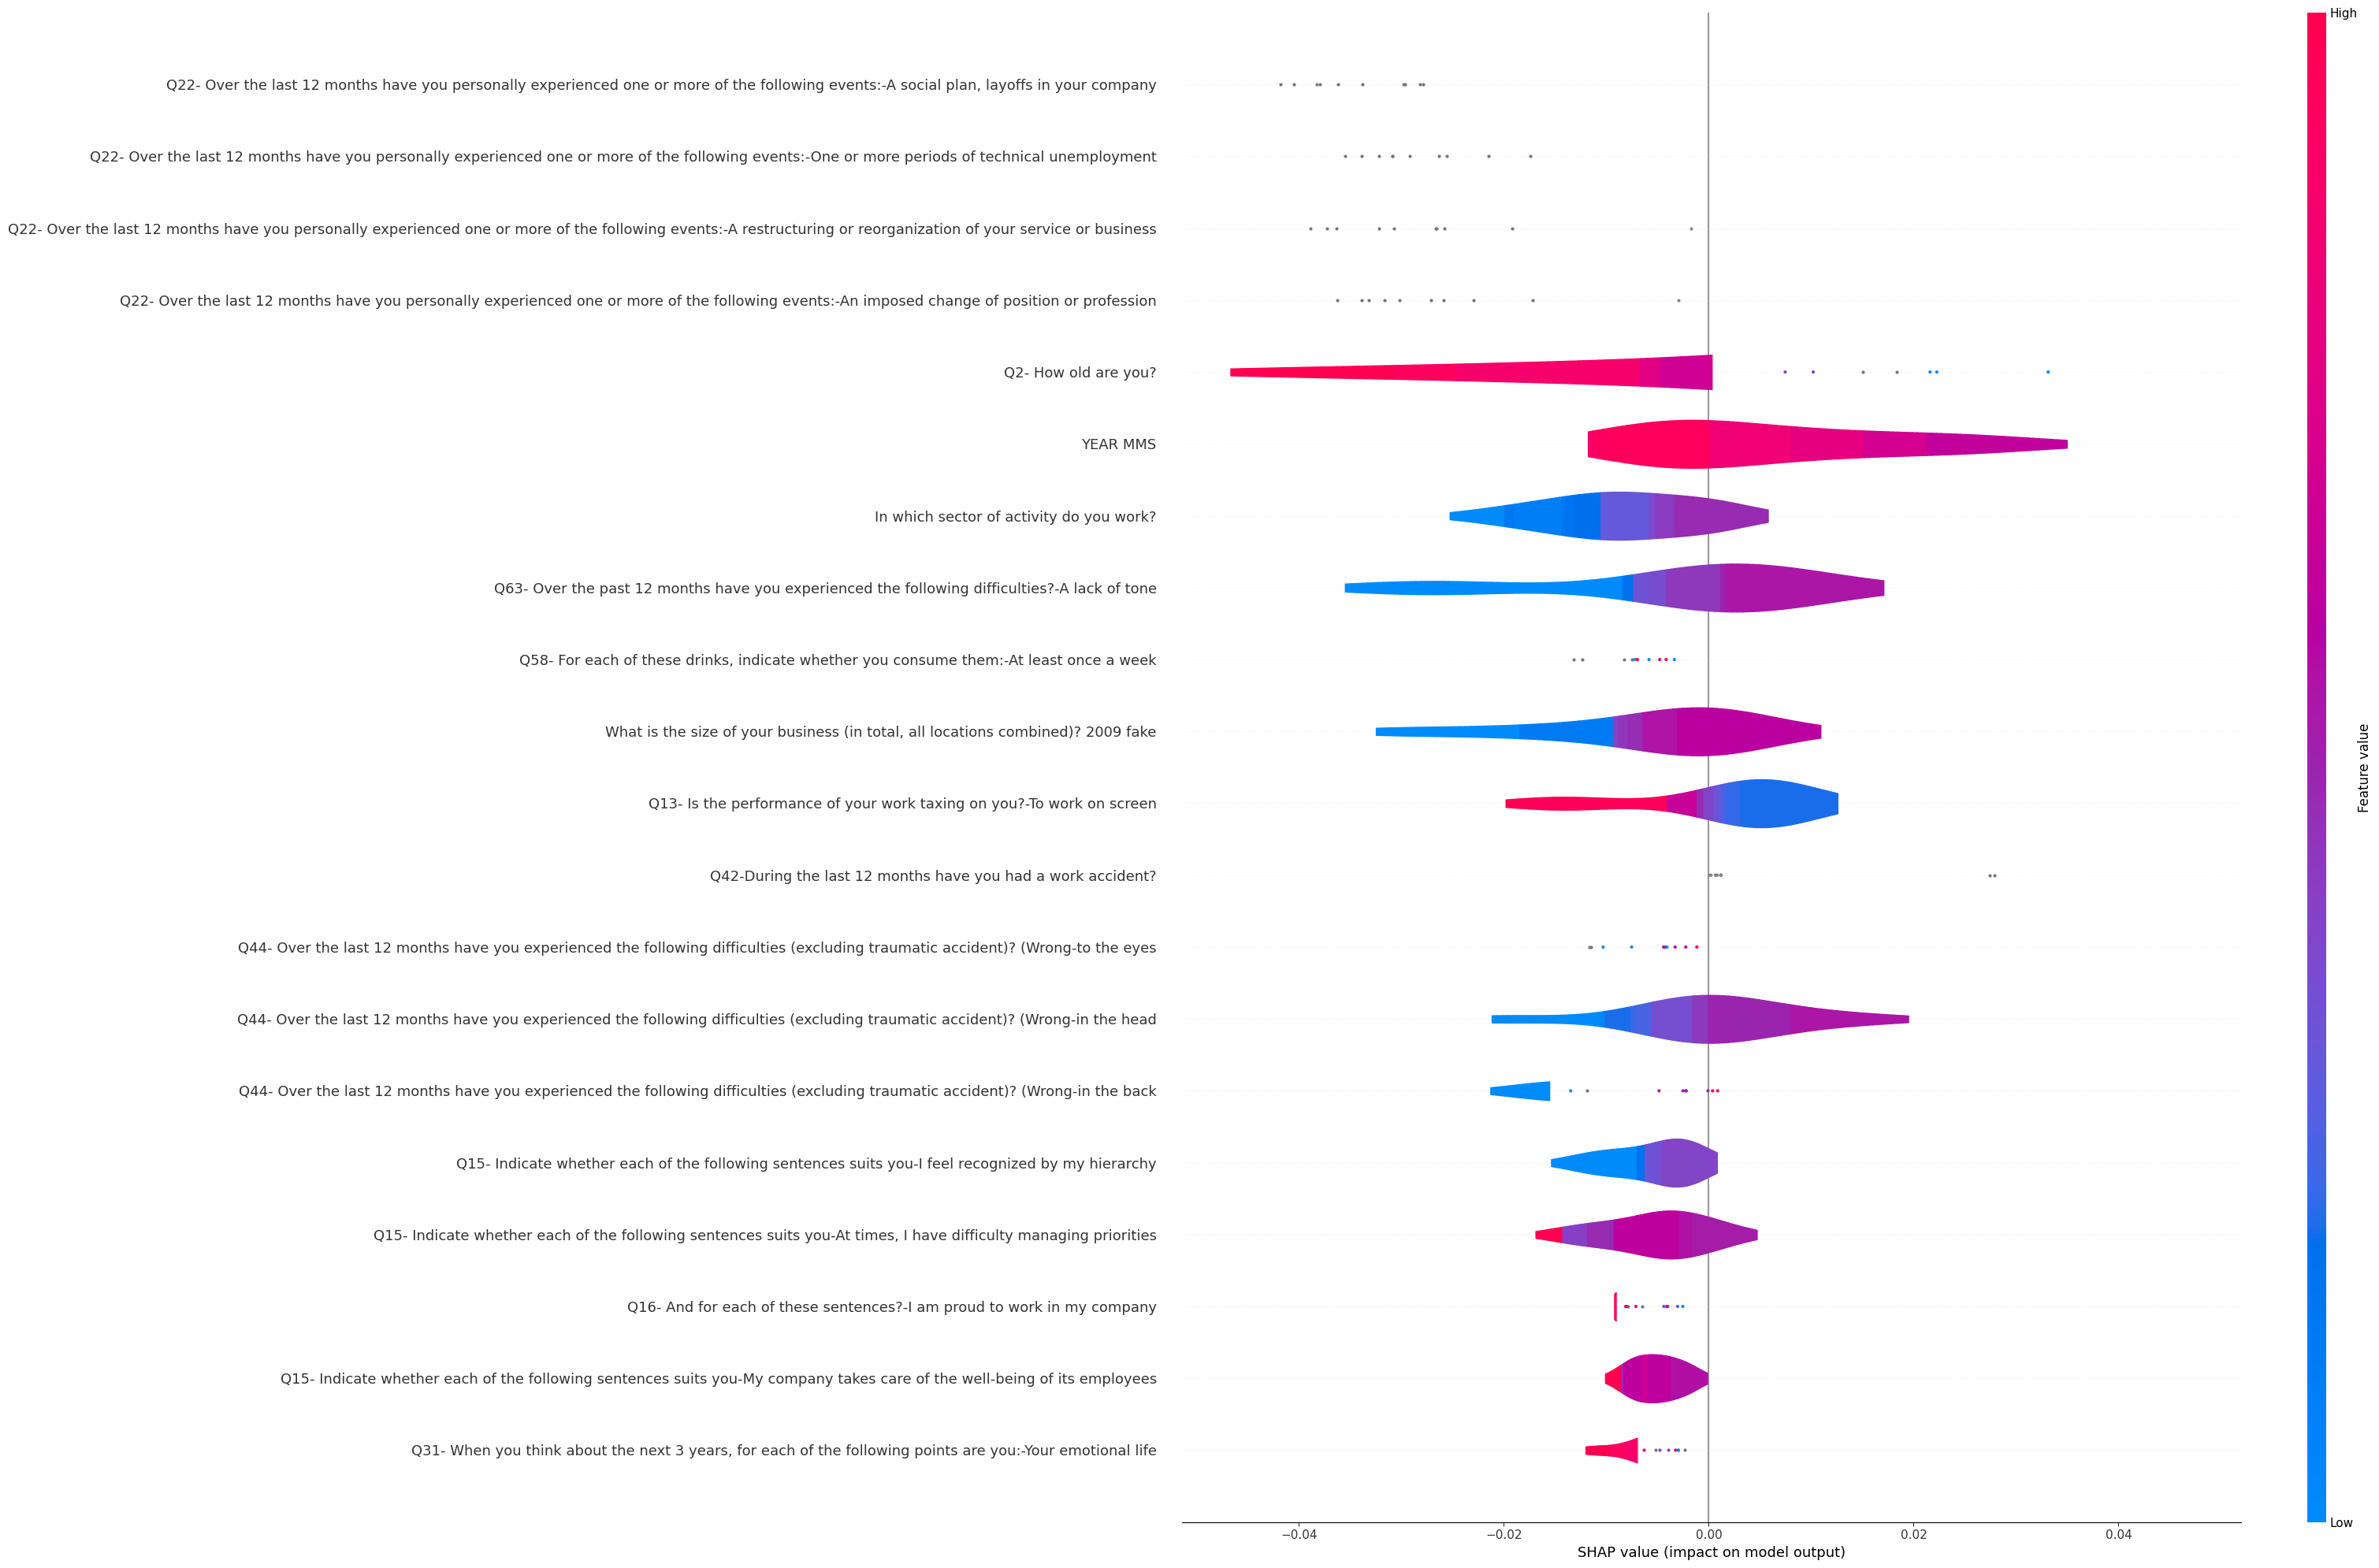

In [14]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_violin_for_10_samples.png')
plt.show()

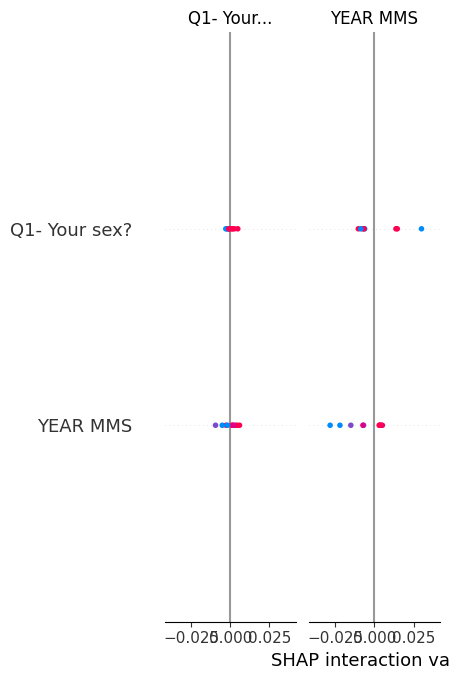

In [15]:
# Shap interaction values

shap.summary_plot(shap_values, X_test[start_index:end_index], plot_type="bar", plot_size=(18,12), show=False)
plt.savefig('outputs/02_01_shap/summary_plot_bar_interaction_for_10_samples.png')
plt.show()

In [16]:
# Calculate shapley values for all data
s_time = time.time()
shap_values_all = explainer.shap_values(X_test)
e_time = time.time()
print(time_e(s_time, e_time, "Shapley values for all data"))

Elapsed time to compute Shapley values for all data: 43 minutes and 38 seconds


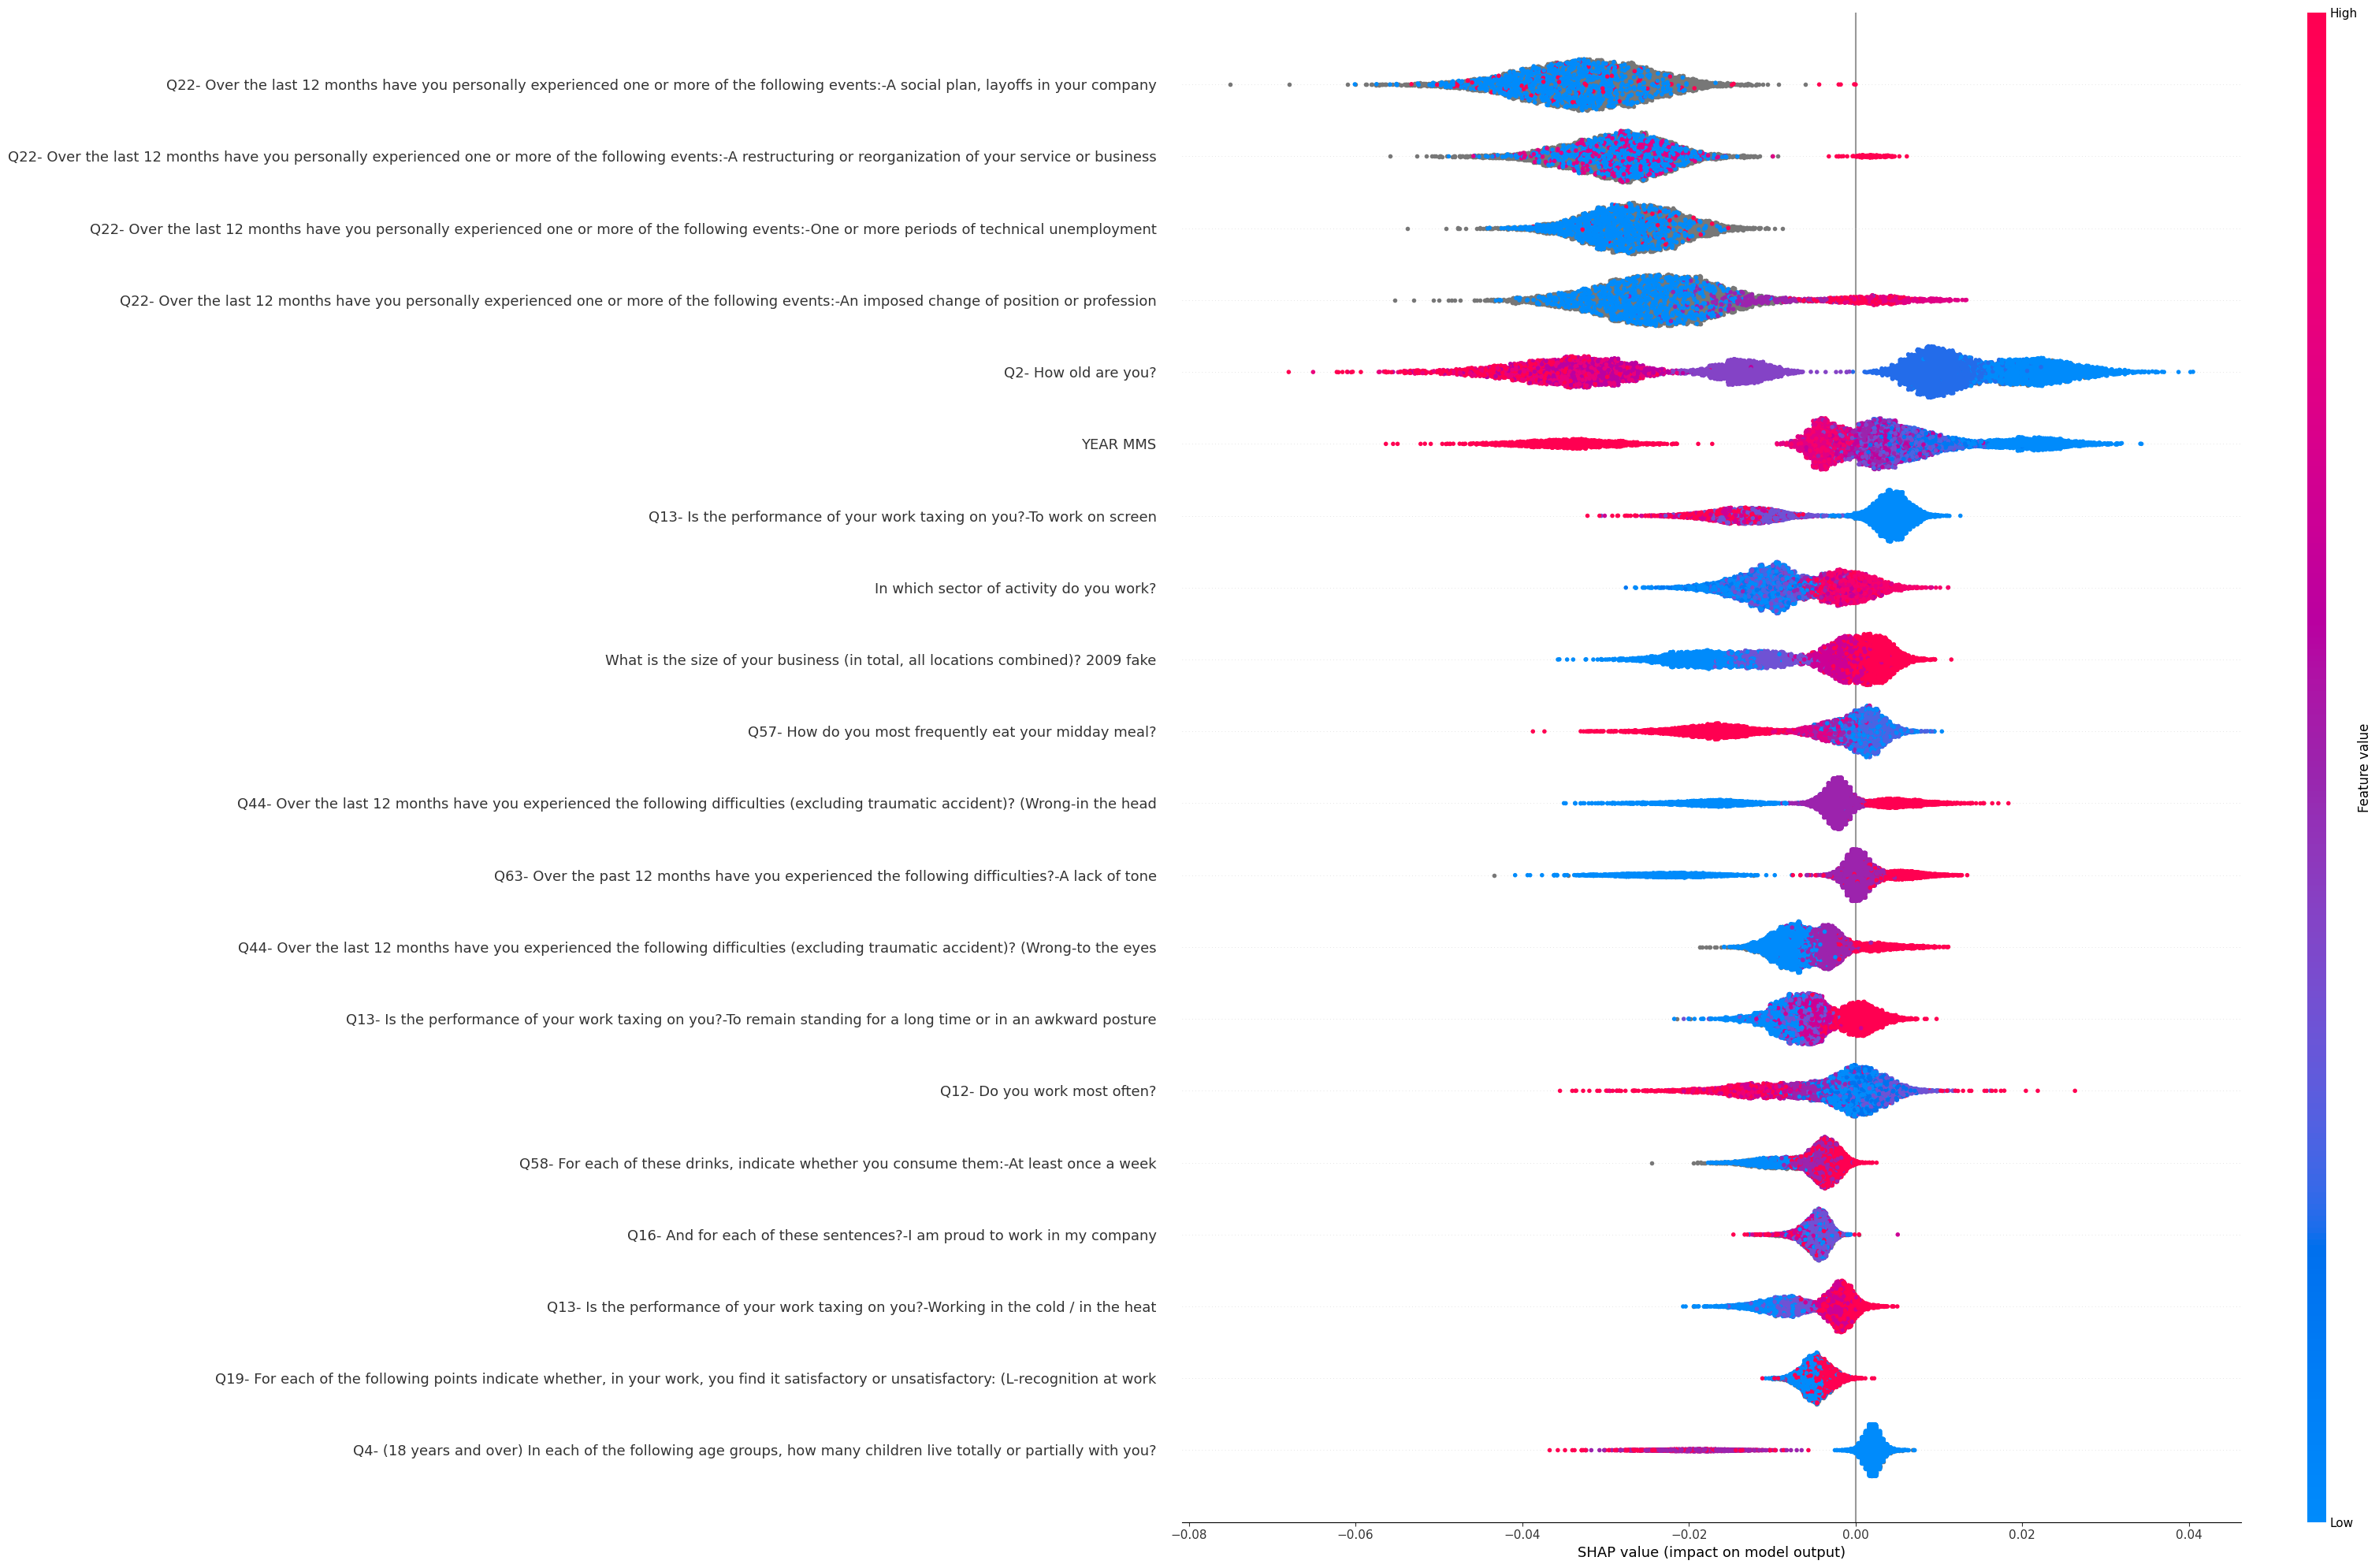

Elapsed time to compute Summary plot for all data: 0 minutes and 2 seconds


In [17]:
s_time = time.time()
shap.summary_plot(shap_values_all[...,1], X_test, plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_all.png')
plt.show()
e_time = time.time()
print(time_e(s_time, e_time, "Summary plot for all data"))

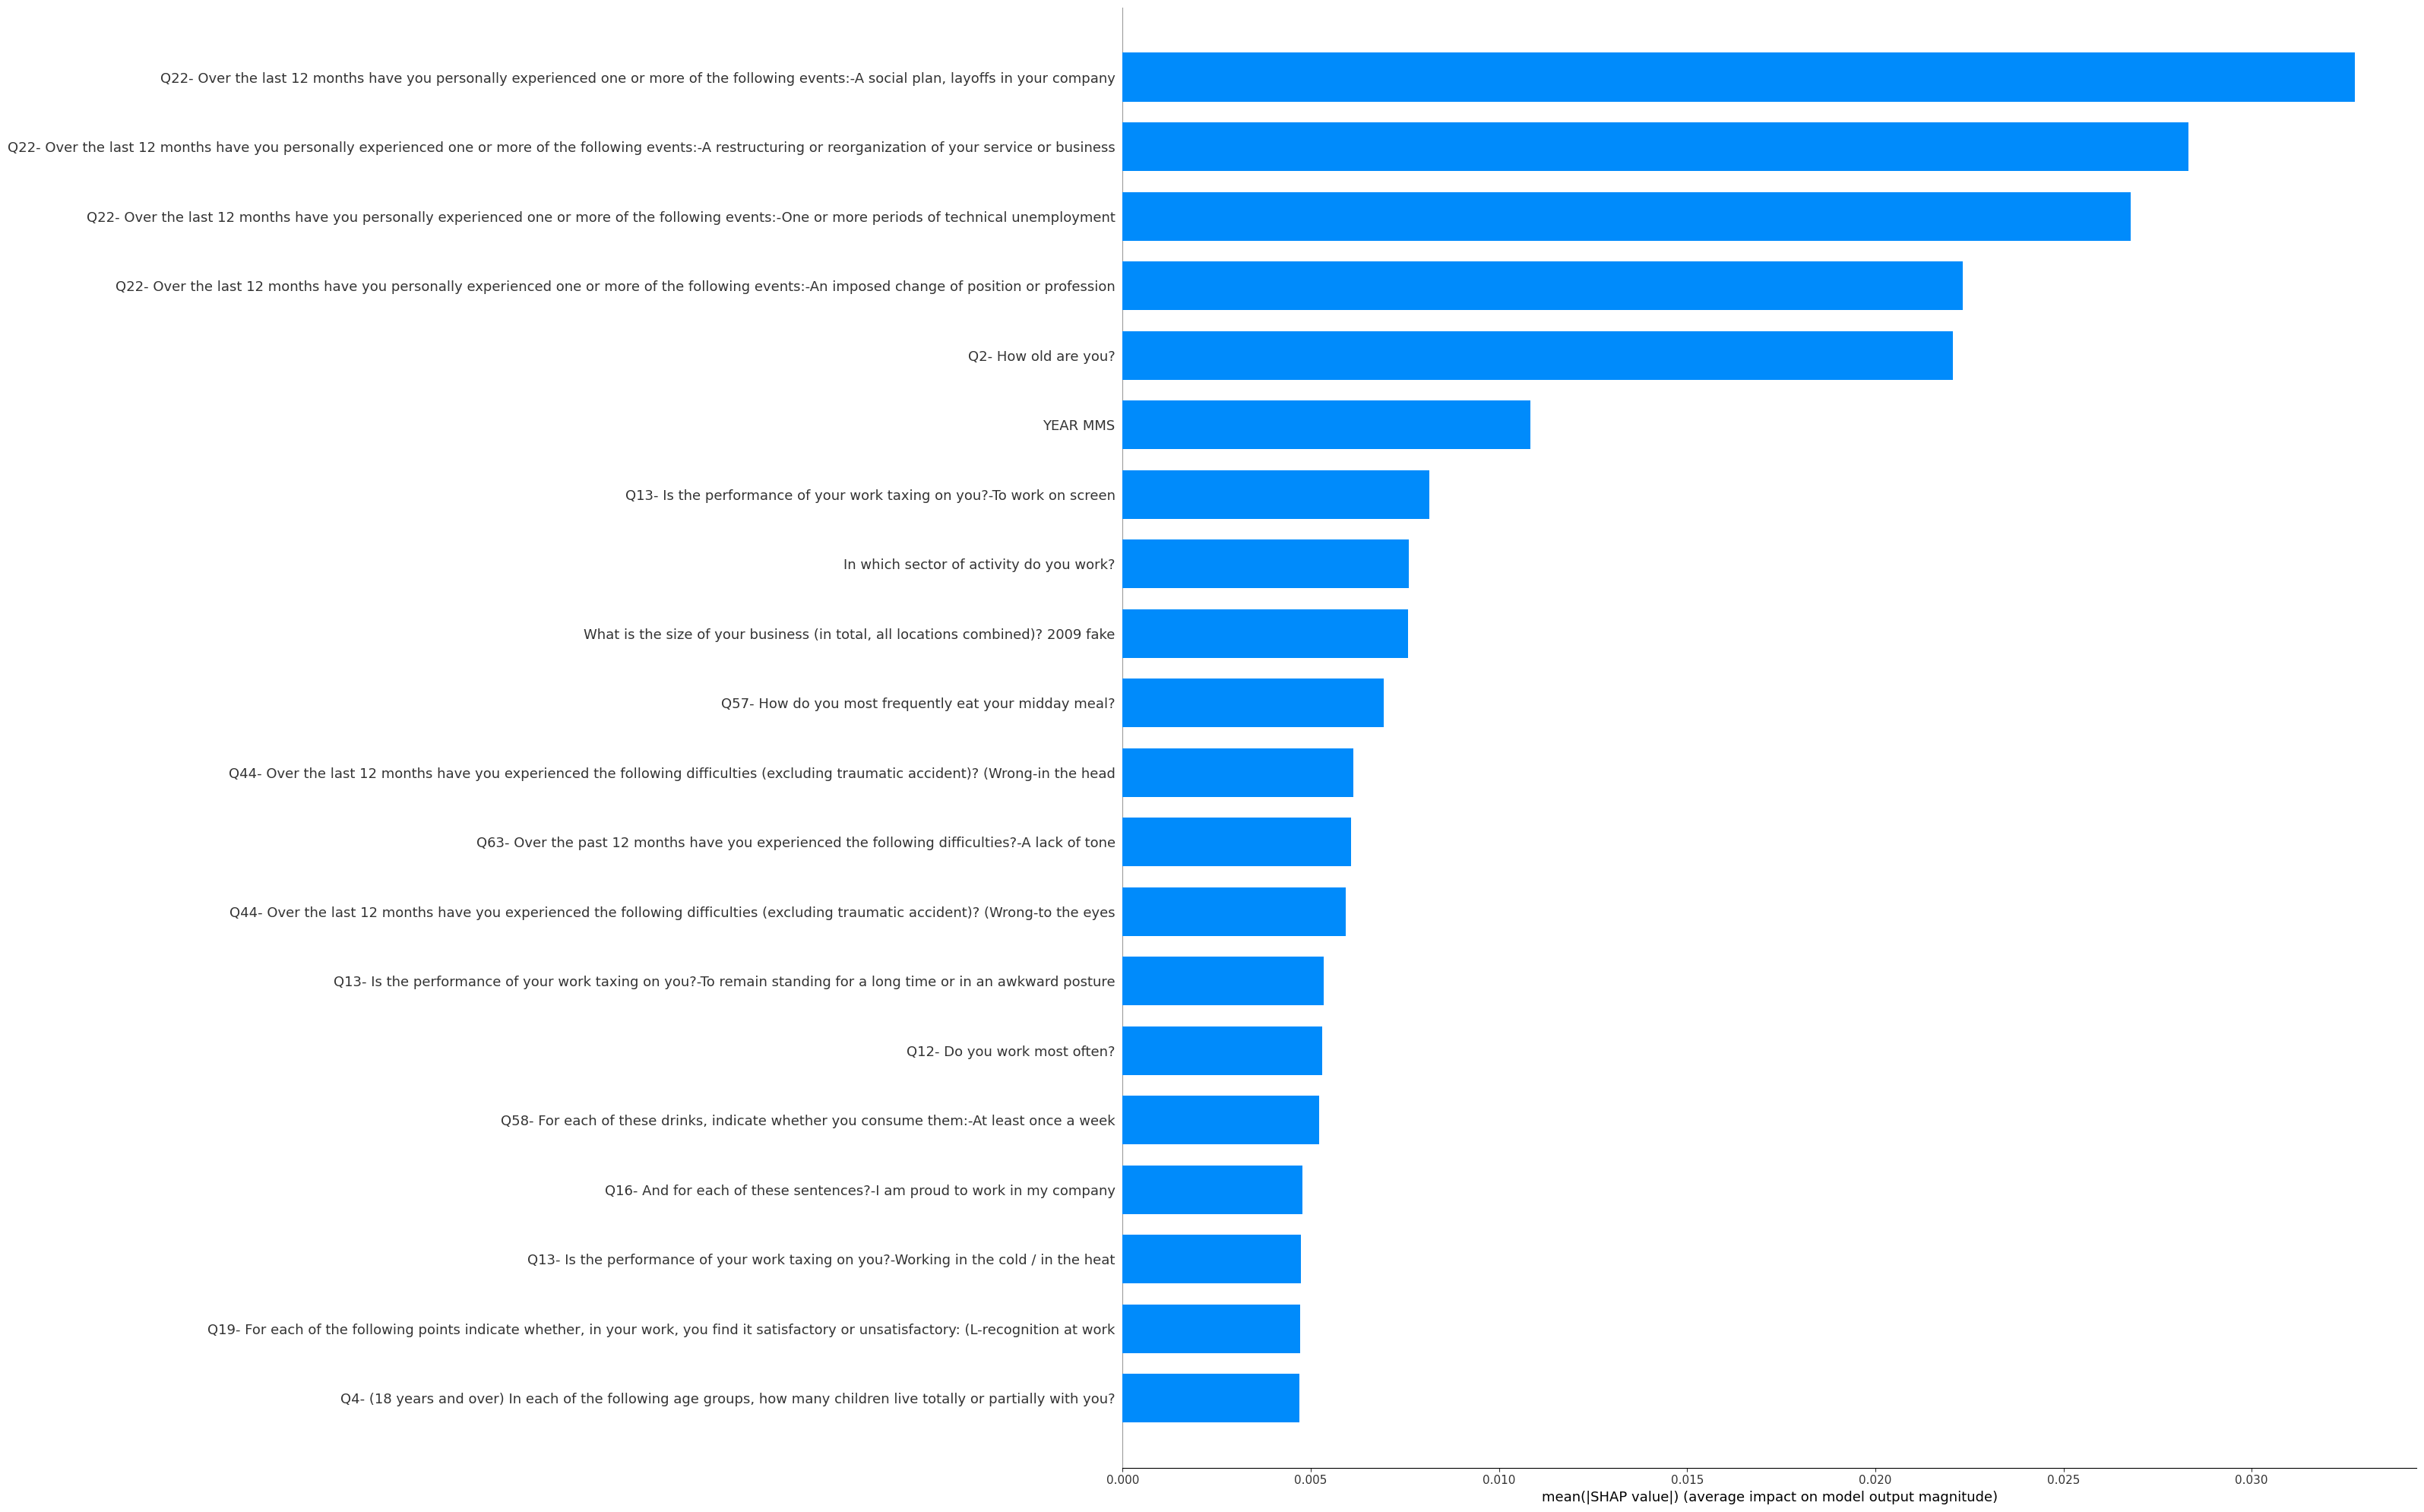

In [18]:
shap.summary_plot(shap_values_all[...,1], X_test, plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_bar_all.png')
plt.show() 

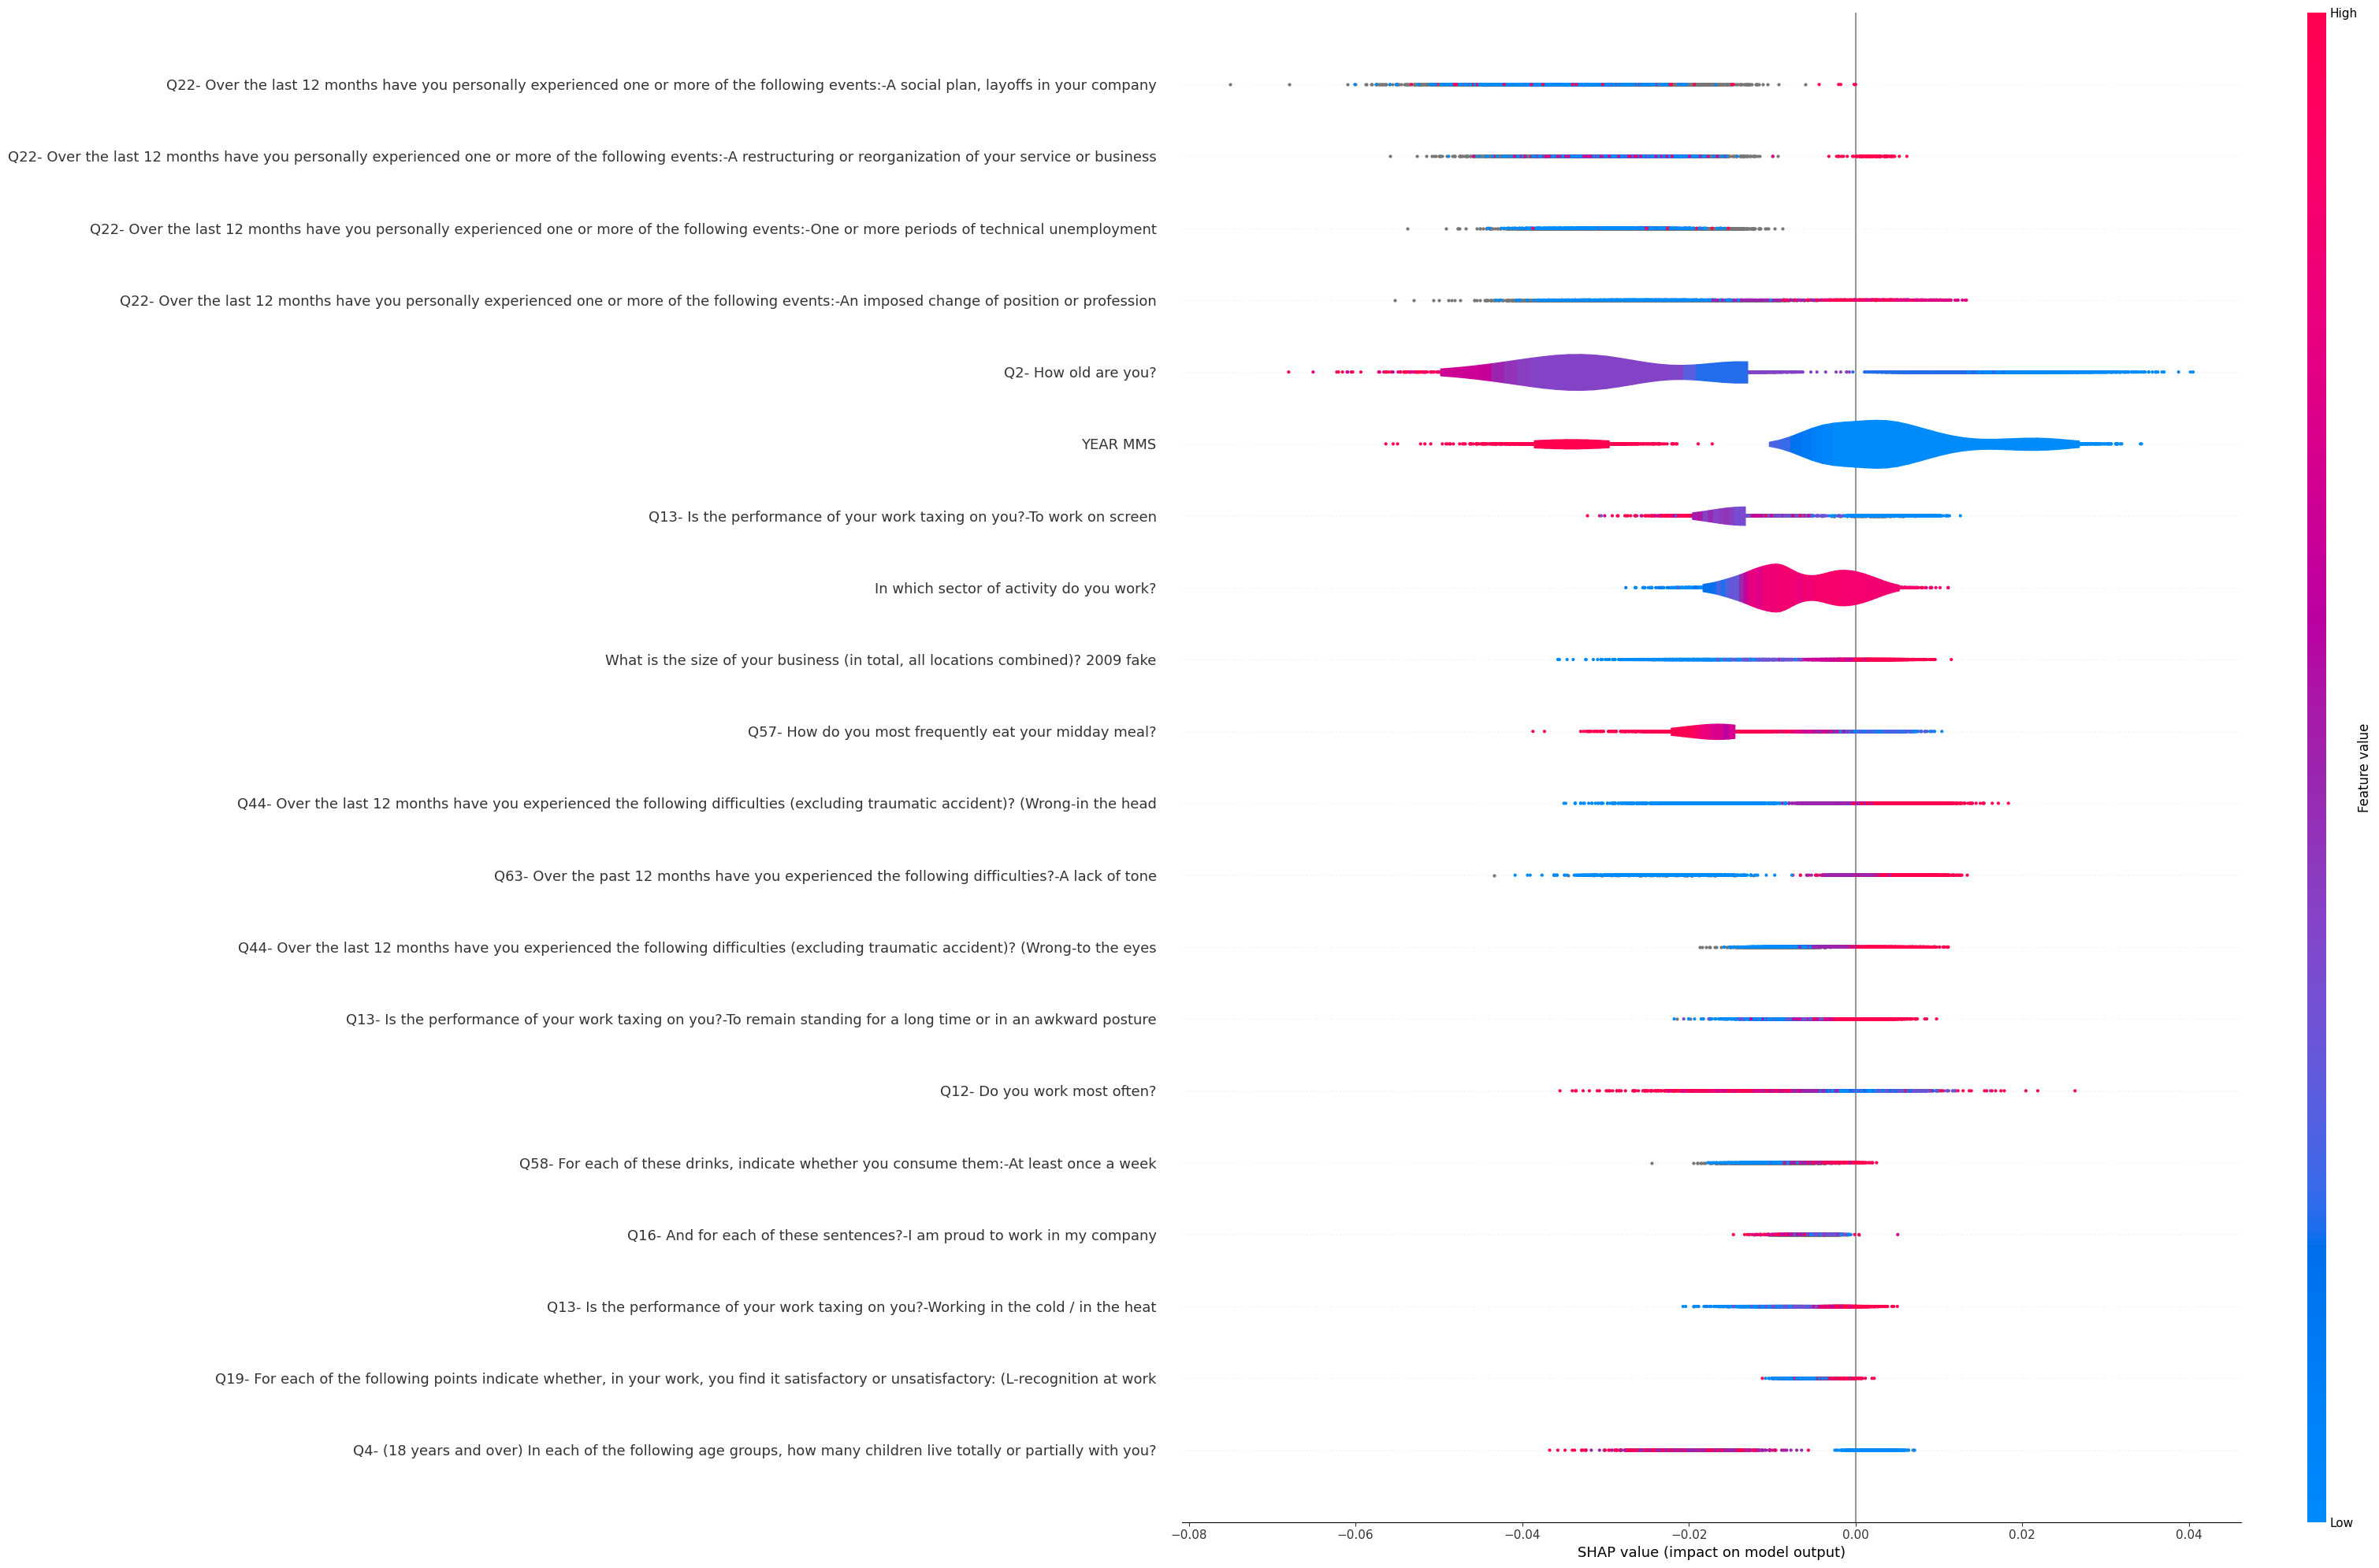

In [19]:
shap.summary_plot(shap_values_all[...,1], X_test, plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_violin_all.png')
plt.show()

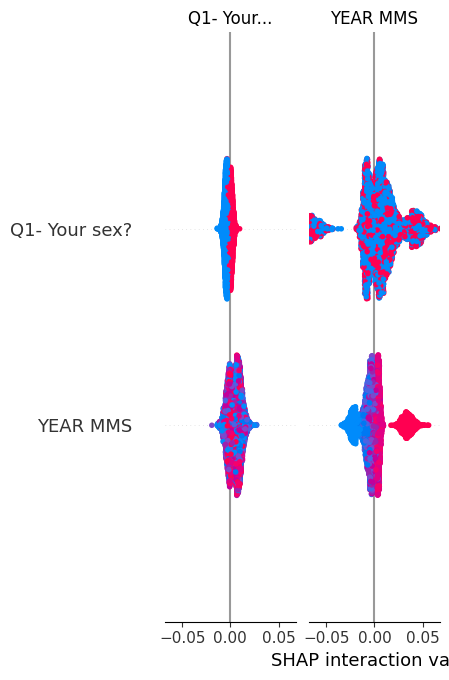

In [20]:
# get the most important feature

shap.summary_plot(shap_values_all, X_test, plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_01_shap/shap_summary_plot_bar_interaction_all.png')
plt.show()

### XGBoost
max_depth = 3

In [21]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)

print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 64.53022322298874
0:[YEAR MMS<10] yes=1,no=2,missing=2,gain=67.9827881,cover=34791
	1:[Q2- How old are you?<3] yes=3,no=4,missing=3,gain=54.3960571,cover=30410
		3:[Q42-During the last 12 months have you had a work accident?<4.00001001] yes=7,no=8,missing=8,gain=60.0628662,cover=16053
			7:leaf=0.223281652,cover=14578
			8:leaf=0.0115254233,cover=1475
		4:[YEAR MMS<3] yes=9,no=10,missing=10,gain=14.3526001,cover=14357
			9:leaf=0.220646173,cover=1269
			10:leaf=0.109260388,cover=13088
	2:[Q2- How old are you?<2] yes=5,no=6,missing=6,gain=0.929872036,cover=4381
		5:[Q15- Indicate whether each of the following sentences suits you-My work allows me to learn new things<8.00000954] yes=11,no=12,missing=12,gain=0.869805574,cover=572
			11:leaf=0.0665499121,cover=571
			12:leaf=1,cover=1
		6:[Q12- Do you work most often?<10] yes=13,no=14,missing=13,gain=0.950989723,cover=3809
			13:leaf=0.0246848743,cover=3808
			14:leaf=1,cover=1



In [22]:
# Calculate model accuracy and F1 score

y_pred = model.predict(Xd) > 0.5
print(f"F1 Score {f1_score(y, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y, y_pred)}")

F1 Score 0.46072522788330905
Accuracy 0.8530079618292087


In [23]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

2.9802322e-08

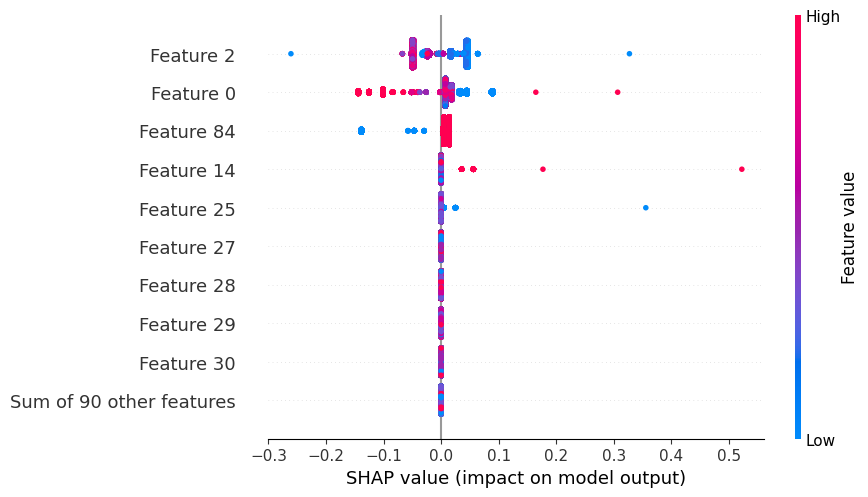

In [24]:
"""
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.
The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution
of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).
"""
shap.plots.beeswarm(explanation, show=False)
plt.savefig('outputs/02_01_shap/shap_beeswarm_plot_xg_4.png')
plt.show()

In [25]:
st = time.time()
clustering = shap.utils.hclust(X, y)
et = time.time()
print(time_e(st, et, "Clustering"))

100it [01:40,  1.08s/it]                       

Elapsed time to compute Clustering: 1 minutes and 42 seconds


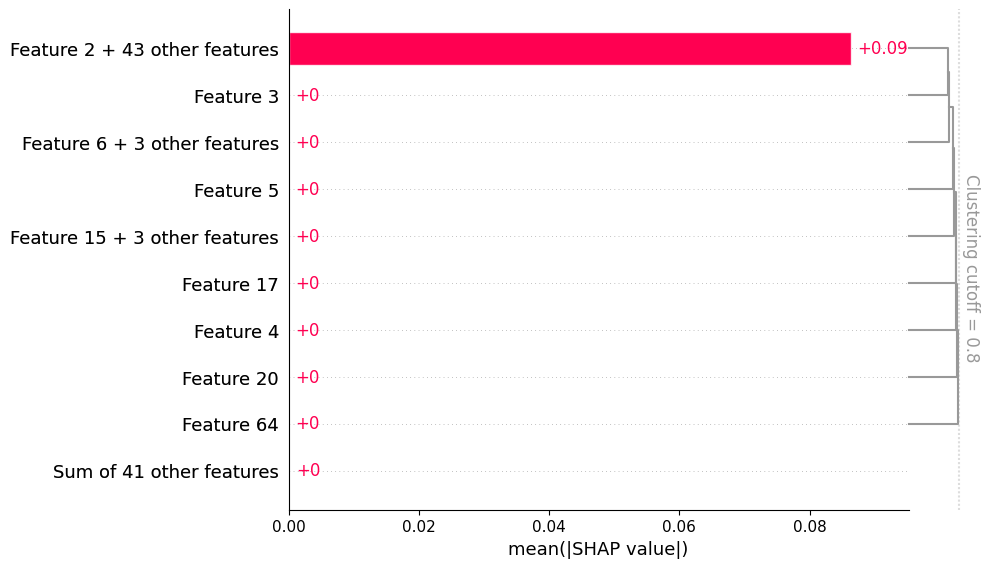

In [26]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=0.8, show=False)
plt.savefig('outputs/02_01_shap/shap_cluster_md_3.png')
plt.show()

### XGBoost

max_depth = 4

In [27]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y) 
model = xgboost.train({"eta": 1, "max_depth": 4, "base_score": 0, "lambda": 0}, Xd, 1)
baseline_error = np.linalg.norm(y - model.predict(Xd))
print("Baseline Model error =", baseline_error)
print(model.get_dump(with_stats=True)[0])

Baseline Model error = 63.06057333419682
0:[YEAR MMS<10] yes=1,no=2,missing=2,gain=67.9827881,cover=34791
	1:[Q2- How old are you?<3] yes=3,no=4,missing=3,gain=54.3960571,cover=30410
		3:[Q42-During the last 12 months have you had a work accident?<4.00001001] yes=7,no=8,missing=8,gain=60.0628662,cover=16053
			7:[YEAR MMS<2] yes=15,no=16,missing=16,gain=170.645447,cover=14578
				15:leaf=0.989473701,cover=285
				16:leaf=0.208003923,cover=14293
			8:[Q34- In your personal life, would you say:-I have personal concerns (emotional life, money, health<3] yes=17,no=18,missing=18,gain=3.54161119,cover=1475
				17:leaf=0.370370358,cover=27
				18:leaf=0.00483425427,cover=1448
		4:[YEAR MMS<3] yes=9,no=10,missing=10,gain=14.3526001,cover=14357
			9:[Q1- Your sex?<2] yes=19,no=20,missing=19,gain=2.9271698,cover=1269
				19:leaf=0.179972932,cover=739
				20:leaf=0.277358502,cover=530
			10:[Q13- Is the performance of your work taxing on you?-To work on screen<2] yes=21,no=22,missing=22,gain=9.35

In [28]:
# Calculate model accuracy and F1 score

y_pred = model.predict(Xd)
y_pred = [1 if i > 0.5 else 0 for i in y_pred] # convert to binary
print(f"F1 Score {f1_score(y, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y, y_pred)}")

F1 Score 0.5148953061329138
Accuracy 0.8610272771693829


In [29]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

1.7881393e-07

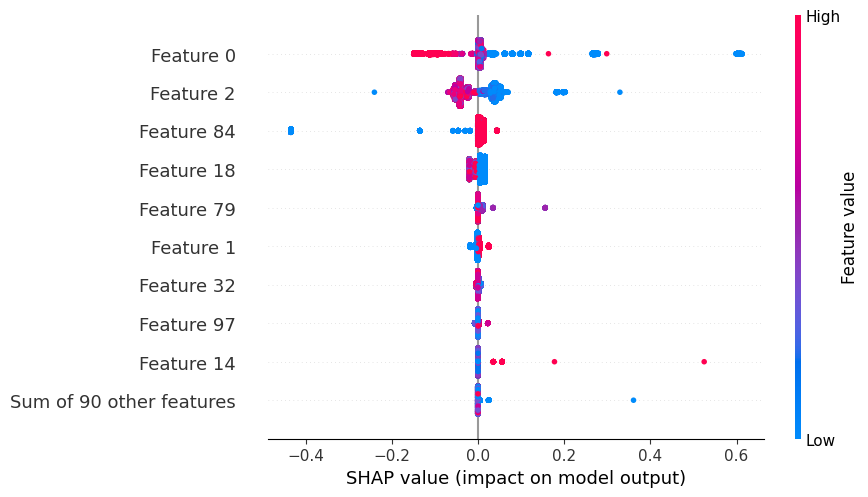

In [30]:
shap.plots.beeswarm(explanation, show=False) # plot the SHAP values
plt.figsize=(32,12)
plt.savefig('outputs/02_01_shap/shap_beeswarm_plot_xg_4.png')
plt.show()

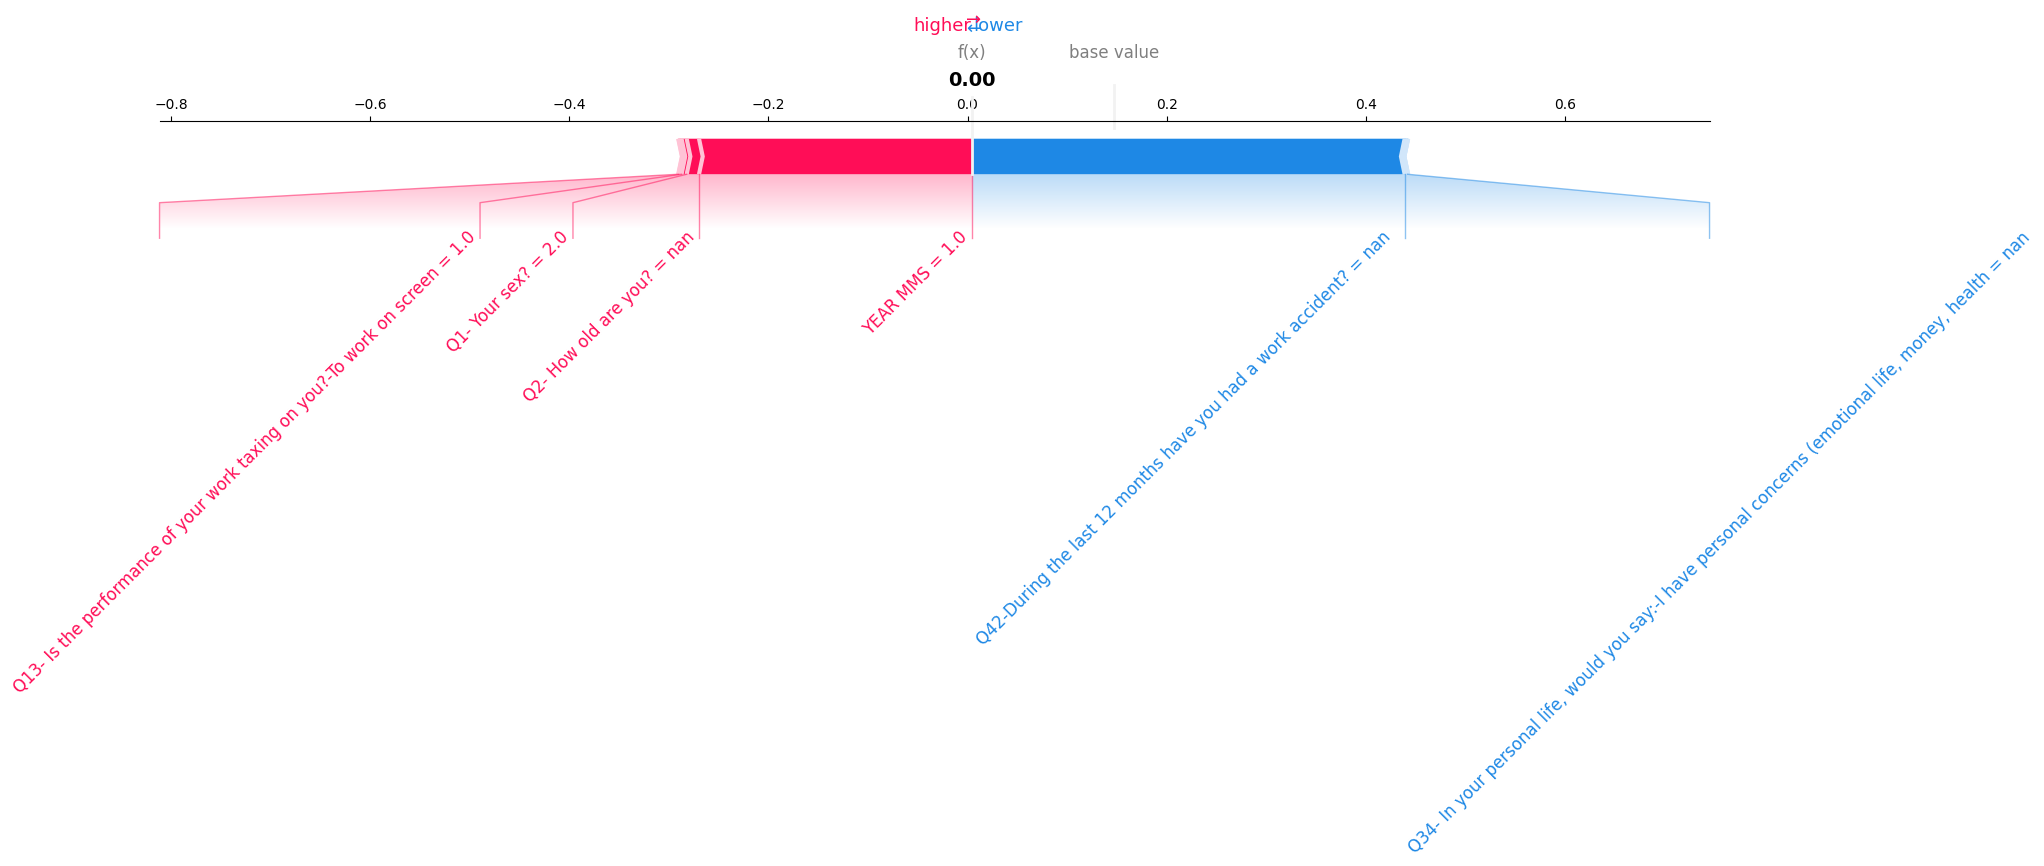

In [31]:
shap.force_plot(explanation.base_values[0], shap_values[0,:], X.iloc[0,:], text_rotation=45, matplotlib=True, show= False) # shows the shap values for the second prediction
plt.savefig('outputs/02_01_shap/shap_force_plot_xg_4.png')
plt.show()

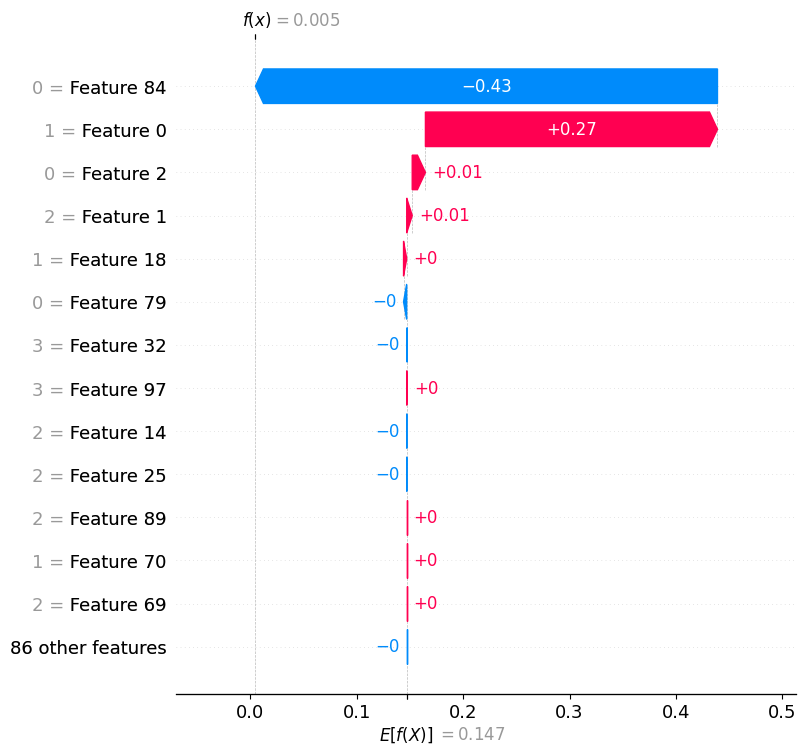

In [32]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(explanation[0,:], max_display=14, show=False)
plt.figsize=(32,18)
plt.savefig('outputs/02_01_shap/shap_waterfall_plot_xg_4.png')
plt.show()

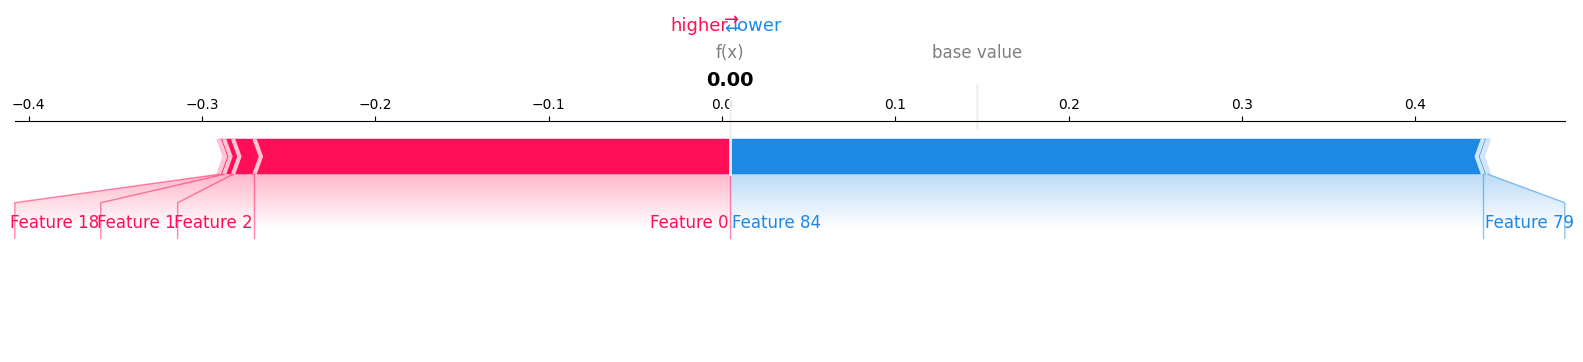

In [33]:
shap.plots.force(explainer.expected_value, shap_values[0, ...], show= False, matplotlib=True) # shap_values[0, ...] is the SHAP values for the first instance in the dataset ... is a numpy slice that means "all of the other axes"
plt.savefig('outputs/02_01_shap/shap_force_plot_xg_4_2.png')
plt.show()

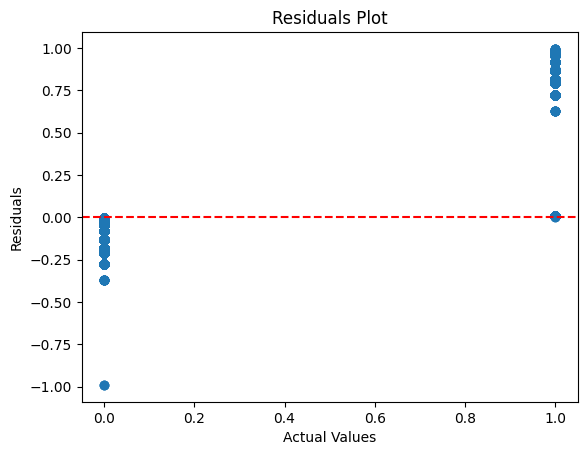

In [34]:
residuals = y - model.predict(Xd)
plt.scatter(y, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# save the plot
plt.savefig('outputs/02_01_shap/residuals_plot.png')
plt.show()

In [35]:
st = time.time()
clustering = shap.utils.hclust(X, y)
et = time.time()
print(time_e(st, et, "Clustering"))

100it [01:46,  1.14s/it]                       

Elapsed time to compute Clustering: 1 minutes and 48 seconds


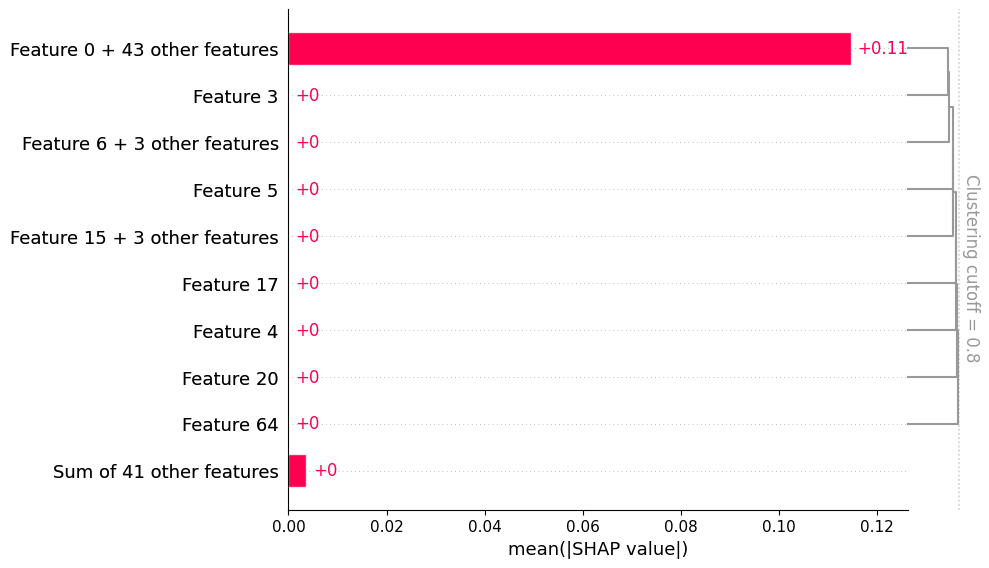

In [36]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=0.8, show=False)
plt.savefig('outputs/02_01_shap/shap_cluster_md_3.png')
plt.show()

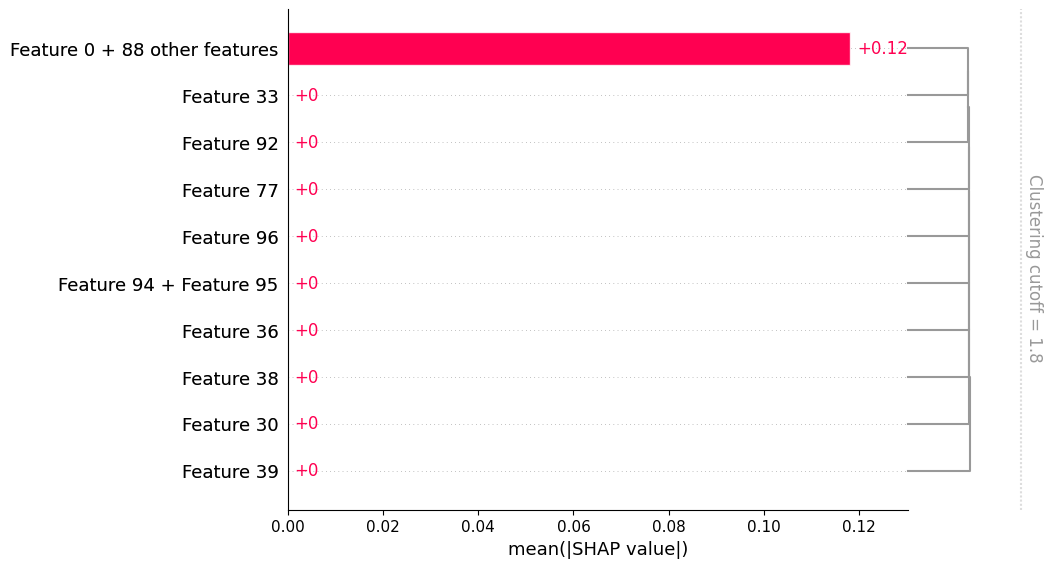

In [37]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=1.8, show=False)
plt.savefig('outputs/02_01_shap/shap_cluster_md_3_1_8.png')
plt.show()